In [124]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from wfdb import Record, Annotation, MultiRecord
import sounddevice as sd
import pandas as pd
import os
from scipy.signal import correlate
from scipy.fft import fft, fftfreq
from typing import Any

In [125]:
plt.style.use("dark_background")

In [126]:
# Vstupní data: https://physionet.org/content/voiced/1.0.0/

In [127]:
def record_info(record: Record) -> None:
    info = [
        ["Název souboru", record.record_name],
        ["Vzorkovací frekvence (Hz)", record.fs],
        ["Délka signálu (vzorky)", record.sig_len],
        ["Počet kanálů", record.n_sig],
        ["Názvy kanálů", ", ".join(record.sig_name)],
        ["Jednotky pro každý kanál", ", ".join(record.units)],
    ]
    info_df = pd.DataFrame(info, columns=["Informace", "Hodnota"])
    display(info_df)


def plot_signal(title: str, signal: np.ndarray, fs: int) -> None:
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(18, 5))
    plt.title(title)
    plt.plot(time, signal, label=title, color="magenta")
    plt.xlabel("Čas (s)")
    plt.ylabel("Amplituda")
    plt.grid(which="both", linestyle="--", alpha=0.2)
    plt.show()


def normalize_signal(signal: np.ndarray) -> np.ndarray:
    min_value = np.min(signal)
    max_value = np.max(signal)
    # Posun signálu tak, aby začínal od nuly
    shifted_signal = signal - min_value
    # Normalizace signál do rozsahu 0 až 1
    normalized_to_1 = shifted_signal / (max_value - min_value)
    # Převod na rozsah -1 až 1
    normalized_signal = normalized_to_1 * 2 - 1
    return normalized_signal

In [128]:
record_info(wfdb.rdrecord("data/voice002"))

,Informace,Hodnota
0,Název souboru,voice002
1,Vzorkovací frekvence (Hz),8000
2,Délka signálu (vzorky),38080
3,Počet kanálů,1
4,Názvy kanálů,voice
5,Jednotky pro každý kanál,NU


In [129]:
# NU = Normalized Unit
# Zde zjišťuji, na jaké rozmezí byla amplituda hlasu normalizována.
# Dedukce je taková, že rozmezí je na intervalu od -1 do 1.

folder = "data"
global_max = -np.inf
global_min = np.inf

for file in os.listdir(folder):
    if file.endswith(".dat"):
        file_path = os.path.join(folder, file[:-4])
        record: Record = wfdb.rdrecord(file_path)
        signal = record.p_signal[:, 0]
        file_max = np.max(signal)
        file_min = np.min(signal)
        if file_max > global_max:
            global_max = file_max
        if file_min < global_min:
            global_min = file_min

print("Celková maximální hodnota signálů:", global_max)
print("Celková minimální hodnota signálů:", global_min)

Celková maximální hodnota signálů: 0.999969482654695
Celková minimální hodnota signálů: -0.9999999997671729


In [130]:
record: Record = wfdb.rdrecord("data/voice004")
signal = normalize_signal(record.p_signal[:, 0])

In [131]:
sd.play(signal, record.fs)
sd.wait()

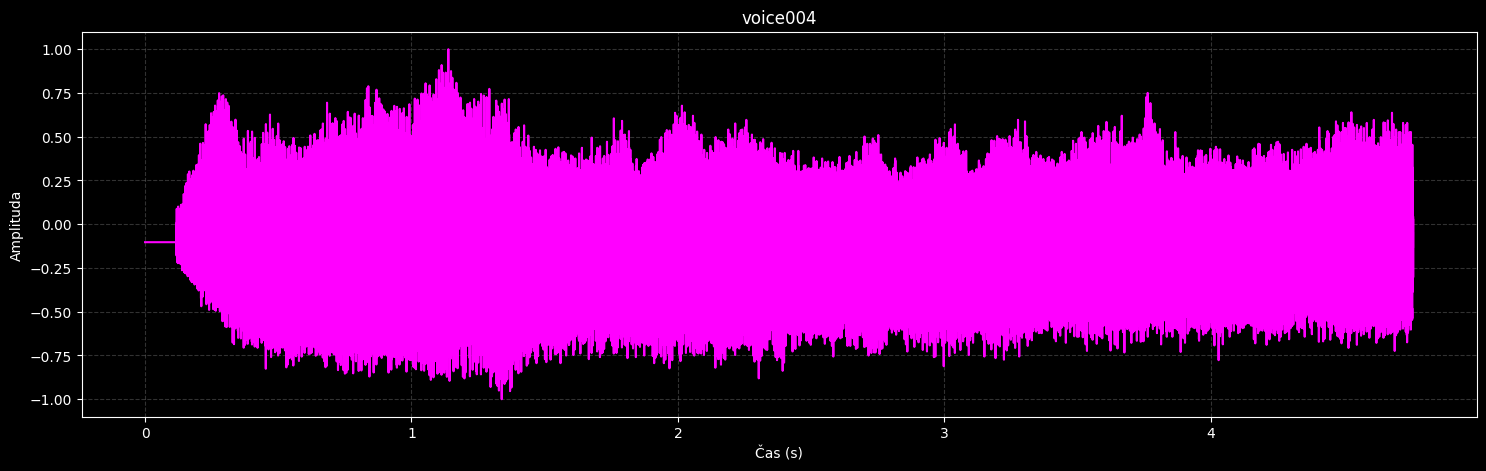

In [132]:
plot_signal("voice004", signal, record.fs)

In [133]:
print("Průměrná hodnota:", np.mean(signal))
print("Směrodatná odchylka:", np.std(signal))
print("Maximum:", np.max(signal))
print("Minimum:", np.min(signal))

Průměrná hodnota: -0.10580183033644966
Směrodatná odchylka: 0.3036797232348306
Maximum: 1.0
Minimum: -1.0


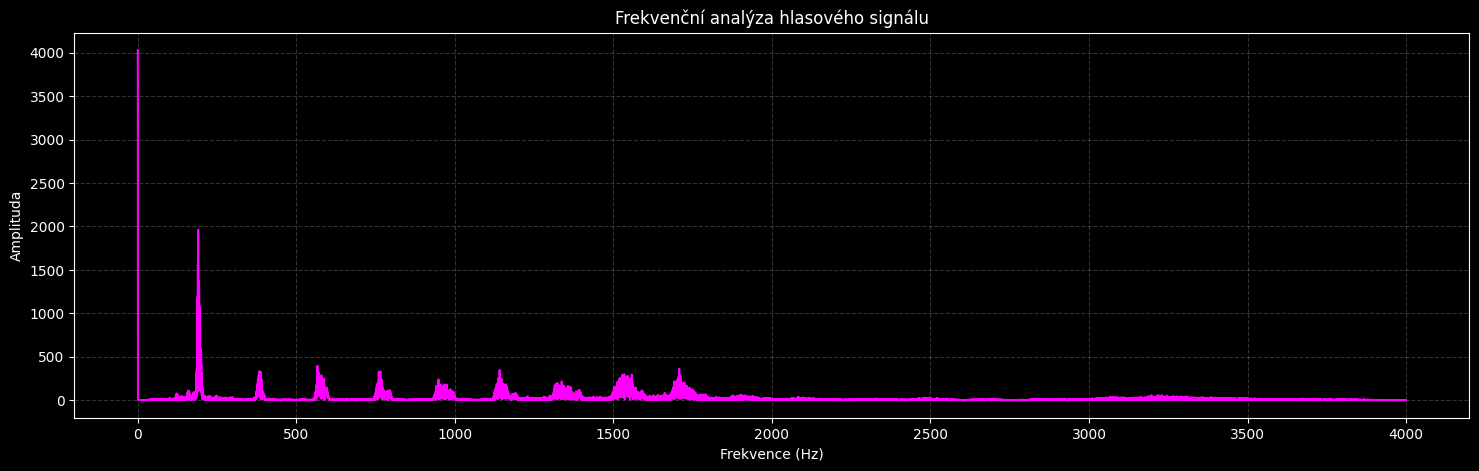

Dominantní frekvence (FFT, Hz): 0.0
Odhad F0 (autokorelace, Hz): 190.47619047619048
Pohlaví: Žena
Klasifikace: Zdravý
Počet harmonických: 42


In [134]:
# Muži: Dominantní frekvence (F0) obvykle mezi 85–180 Hz.
# Ženy: Dominantní frekvence (F0) obvykle mezi 165–255 Hz.
# Pokud dominantní frekvence spadá mimo tyto rozsahy, můžeme ji klasifikovat jako "neurčitá".


def classify_signal(signal: np.ndarray, fs: int, plot_graph=True) -> dict:
    n = len(signal)
    frequency_signal = fft(signal)
    frequencies = fftfreq(n, 1 / fs)
    positive_freq = frequencies[: n // 2]
    magnitude = np.abs(frequency_signal[: n // 2])

    autocorr = correlate(signal, signal, mode="full")
    autocorr = autocorr[len(autocorr) // 2 :]

    min_lag = int(fs / 300)  # Maximální F0 ~ 300 Hz
    max_lag = int(fs / 50)  # Minimální F0 ~ 50 Hz
    lag_range = autocorr[min_lag:max_lag]
    lag = np.argmax(lag_range) + min_lag
    f0 = fs / lag

    if 85 <= f0 <= 180:
        gender = "Muž"
    elif 165 <= f0 <= 255:
        gender = "Žena"
    else:
        gender = "Neurčité"

    threshold = 0.1 * np.max(magnitude)
    harmonic_count = np.sum(magnitude > threshold)
    diagnosis = "Zdravý" if harmonic_count > 5 else "Nemocný"

    if plot_graph:
        plt.figure(figsize=(18, 5))
        plt.title("Frekvenční analýza hlasového signálu")
        plt.plot(positive_freq, magnitude, color="magenta")
        plt.xlabel("Frekvence (Hz)")
        plt.ylabel("Amplituda")
        plt.grid(which="both", linestyle="--", alpha=0.2)
        plt.show()

    return {
        "Dominantní frekvence (FFT, Hz)": positive_freq[np.argmax(magnitude)],
        "Odhad F0 (autokorelace, Hz)": f0,
        "Pohlaví": gender,
        "Klasifikace": diagnosis,
        "Počet harmonických": harmonic_count,
    }


# Použití funkce
result = classify_signal(signal, record.fs)
for key, value in result.items():
    print(f"{key}: {value}")

In [135]:
def extra_hea_data(header: Record | MultiRecord) -> dict[str, Any]:
    comment: str = header.comments[0]
    age = comment.split("<age>:")[1].split("<")[0].strip()
    sex = comment.split("<sex>:")[1].split("<")[0].strip()
    diagnosis = comment.split("<diagnoses>:")[1].split("<")[0].strip()
    medications = comment.split("<medications>:")[1].split("<")[0].strip()
    return {
        "Soubor": header.file_name[0],
        "Věk": int(age) if age else None,
        "Pohlaví": "Muž" if sex == "M" else "Žena" if sex == "F" else None,
        "Diagnóza": diagnosis,
        "Medikace": medications,
    }


def extract_all_hea_data(folder: str) -> pd.DataFrame:
    extracted_data = []
    for file in os.listdir(folder):
        if file.endswith(".hea"):
            file_path = os.path.join(folder, file[:-4])  # Odebrání přípony .hea
            header = wfdb.rdheader(file_path)
            extracted_data.append(extra_hea_data(header))
    return pd.DataFrame(extracted_data)


hea_data = extract_all_hea_data("data")
display(hea_data)

,Soubor,Věk,Pohlaví,Diagnóza,Medikace
0,voice001.dat,32,Muž,hyperkinetic dysphonia,none
1,voice002.dat,55,Muž,healthy,none
2,voice003.dat,34,Muž,hyperkinetic dysphonia,none
3,voice004.dat,28,Žena,hypokinetic dysphonia,none
4,voice005.dat,54,Žena,hypokinetic dysphonia,none
...,...,...,...,...,...
203,voice204.dat,59,Žena,healthy,none
204,voice205.dat,30,Žena,hyperkinetic dysphonia,none
205,voice206.dat,22,Žena,healthy,none
206,voice207.dat,30,Žena,healthy,none
